In [1]:
import os
import re
import sys
import yaml
import multiprocessing
import itertools
import logging

import pypsa

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

import cartopy
import cartopy.io.shapereader as shpreader
import pycountry
import cartopy.crs as ccrs

sns.set_theme(style="whitegrid")

# Replace __file__ with the absolute path of the notebook file
notebook_path = "/home/koen/research/eu-hydrogen/notebooks/scratch.ipynb"

# Insert ../scripts/ to sys.path
sys.path.insert(
    0, os.path.abspath(os.path.join(os.path.dirname(notebook_path), "..", "scripts"))
)

ERROR 1: PROJ: proj_create_from_database: Open of /fp/homes01/u01/ec-koenvg/.conda/envs/my_base/envs/eu-hydrogen/share/proj failed


In [2]:
# Set font type: other we get type3 fonts which are problematic for ipe
mpl.rcParams['pdf.fonttype'] = 42

# Ignore INFO:fontTools logging messages
logging.getLogger('fontTools').setLevel(logging.WARNING)

In [3]:
config_fn = "../config/eu-hydrogen.yaml"
config = yaml.safe_load(open(config_fn))

config_default = yaml.safe_load(open("../config/config.default.yaml"))

results_dir = "../results"

scenarios_fn = config["run"]["scenarios"]["file"]
scenarios = yaml.safe_load(open(os.path.join("..", scenarios_fn)))

use_cache = True

In [4]:
green = "#5fc983"
dark_green = "#4b7559"
max_c = "#c95f7e"
min_c = "#975fc9"

titlesize = 9
textsize = 8
labelsize = 7

# cm in inch
cm = 1 / 2.54

H2_MAX = 110

targets = [(2040, 25)]

In [5]:
def lighten_color(hex_color, amount=0.5):
    # Convert hex color to RGB
    rgb_color = mcolors.hex2color(hex_color)
    # Define white color in RGB
    white = (1, 1, 1)
    # Blend the colors
    blended_color = tuple(max((1 - amount) * x + amount * y, 0) for x, y in zip(rgb_color, white))
    # Convert RGB to hex
    return mcolors.to_hex(blended_color)

In [6]:
stat_names = [
    "h2prod",
    "imports",
    "system_cost",
    "obj_bound_dual",
    "h2price",
    "h2value",
    "co2seq",
    "dac",
    "captured_co2",
    "elec_cap",
    "elec_cf",
    "total_onwind",
    "total_offwind",
    "total_solar",
    "total_nuclear",
    "total_h2_storage",
]


def stats(n: pypsa.Network):
    # H2
    i = n.links.loc[n.links.carrier.isin(["H2 Electrolysis"])].index
    MWh_h2 = -(
        n.links_t.p1.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()
    h2prod = (MWh_h2 / 33.33) / 1e6

    # Imports
    i = n.generators.loc[n.generators.index.str.contains("green import")].index
    imports = (
        n.generators_t.p.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum() / 1e6

    # System cost
    system_cost = n.statistics.capex().sum() + n.statistics.opex().sum()

    # System cost bound dual
    obj_bound_dual = (
        n.global_constraints.at["total_system_cost", "mu"]
        if "total_system_cost" in n.global_constraints.index
        else np.nan
    )

    # H2 price
    h2_buses = n.buses.index[n.buses.carrier == "H2"]
    h2price = (n.buses_t.marginal_price[h2_buses].mean(axis=1) * n.snapshot_weightings.generators).sum() / 8760

    # Total value of H2 produced
    elec_i = n.links.index[n.links.carrier == "H2 Electrolysis"]
    h2value = -(
        n.snapshot_weightings.generators
        @ (
            n.links_t.p1[elec_i].rename(n.links.bus1, axis=1)
            * n.buses_t.marginal_price[n.links.bus1[elec_i]]
        )
    ).sum()

    # Total CO2 sequestration
    co2seq = n.stores.loc[n.stores.carrier == "co2 sequestered", "e_nom_opt"].sum()

    # Total amount of CO2 captured by DAC
    dac_i = n.links.loc[n.links.carrier == "DAC"].index
    dac = (
        n.links_t.p0.loc[:, dac_i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()

    # Total amount of CO2 captured, including industry, BECCS, etc.
    total = 0
    for i in [1, 2, 3, 4]:
        links_i = n.links.loc[n.links.__getattr__(f"bus{i}") == "co2 stored"].index
        co2 = n.links_t.__getattr__(f"p{i}").loc[:, links_i]
        co2 = co2.clip(upper=0)
        total -= (co2.sum(axis=1) * n.snapshot_weightings.generators).sum()

    captured_co2 = total / 1e6

    # Total installed capacity of electrolysers
    elec_cap = n.links.loc[elec_i, "p_nom_opt"].sum()

    # Mean capacity factor of electrolysers
    if elec_cap > 0:
        elec_cf = (
            n.links_t.p0.loc[:, elec_i].sum(axis=1) * n.snapshot_weightings.generators
        ).sum() / (elec_cap * n.snapshot_weightings.generators.sum())
    else:
        elec_cf = np.nan

    # Total installed onshore wind
    total_onwind = n.generators.loc[n.generators.carrier == "onwind", "p_nom_opt"].sum()

    # Total installed offshore wind
    total_offwind = n.generators.loc[
        n.generators.carrier.isin(["offwind-ac", "offwind-dc", "offwind-float"]),
        "p_nom_opt",
    ].sum()

    # Total installed solar
    total_solar = n.generators.loc[n.generators.carrier == "solar", "p_nom_opt"].sum()

    # Total installed nuclear
    nuclear_i = n.links.index[n.links.carrier == "nuclear"]
    total_nuclear = (n.links.loc[nuclear_i, "p_nom_opt"] * n.links.loc[nuclear_i, "efficiency"]).sum()

    # Total installed H2 storage
    total_h2_storage = n.stores.loc[n.stores.carrier == "H2 Store", "e_nom_opt"].sum()

    return {
        "h2prod": h2prod,
        "imports": imports,
        "system_cost": system_cost,
        "obj_bound_dual": obj_bound_dual,
        "h2price": h2price,
        "h2value": h2value,
        "co2seq": co2seq,
        "dac": dac,
        "captured_co2": captured_co2,
        "elec_cap": elec_cap,
        "elec_cf": elec_cf,
        "total_onwind": total_onwind,
        "total_offwind": total_offwind,
        "total_solar": total_solar,
        "total_nuclear": total_nuclear,
        "total_h2_storage": total_h2_storage,
    }

In [7]:
if not use_cache:
    nets = {}

    # Get the overall scenario names as the top level keys in scenarios dict
    if config["run"]["name"] == "all":
        scenario_list = list(scenarios.keys())
    else:
        scenario_list = [config["run"]["name"]]

    # Assume that the following are uniquely defined for each run:
    ll = config["scenario"]["ll"][0]
    clusters = config["scenario"]["clusters"][0]
    opts = config["scenario"]["opts"][0]

    # The following are taken to vary for each run.
    sector_opts = config["scenario"]["sector_opts"]
    planning_horizons = config["scenario"]["planning_horizons"]
    slacks = config["scenario"]["slack"]
    senses = ["min", "max"]

    resolution = None

    # If resolution not none, replace all instances of "\d+seg" with resolution in sector_opts
    if resolution is not None:
        sector_opts = [
            re.sub(r"\d+seg", resolution, s) if "seg" in s else s + "-" + resolution
            for s in sector_opts
        ]

    def load_stats(file):
        return (
            stats(pypsa.Network(file))
            if os.path.exists(file)
            else {v: np.nan for v in stat_names}
        )

    index = list(
        itertools.product(scenario_list, sector_opts, planning_horizons, slacks, senses)
    )
    index_opt = list(
        itertools.product(scenario_list, sector_opts, planning_horizons, [0], ["opt"])
    )

    with multiprocessing.Pool(30) as pool:
        networks = pool.map(
            load_stats,
            [
                f"{results_dir}/{s}/postnetworks/base_s_{clusters}_l{ll}_{opts}_{o}_{h}_{sense}{slack}.nc"
                for s, o, h, slack, sense in index
            ],
        )

        networks.extend(
            pool.map(
                load_stats,
                [
                    f"{results_dir}/{s}/postnetworks/base_s_{clusters}_l{ll}_{opts}_{o}_{h}.nc"
                    for s, o, h, _, _ in index_opt
                ],
            )
        )

    networks = dict(zip(index + index_opt, networks))

In [8]:
if not use_cache:
    pd.DataFrame(networks).T.reset_index()

In [9]:
if not use_cache:
    df = pd.DataFrame(networks).T.reset_index()
    df.columns = ["scenario", "opts", "horizon", "slack", "sense"] + stat_names

    # Split the "scenario" column into "year" and "biomass"; has format "Y<year>_B<biomass_flag>"
    df[["year", "B"]] = df["scenario"].str.extract(r"Y(\d+)_B([a-z])")

    # Drop the "scenario" column
    df.drop(columns=["scenario"], inplace=True)

    # Strip any suffix of the form "-\d+seg" from the "opts" column
    df["opts"] = df["opts"].str.replace(r"-\d+seg", "", regex=True)

    # The "opts" column has the form "XX-YY-ZZ-..."; we want to split this into separate columns and keep only the last character
    flags = list(map(lambda s: s[0], df.at[0, "opts"].split("-")))
    df[flags] = df["opts"].str.split("-", expand=True).map(lambda s: s[-1])
    df.drop(columns=["opts"], inplace=True)

    # Add a column concatenating the year and flags
    df["scenario"] = df["year"] + df["B"] + df[flags].apply(lambda x: "".join(x), axis=1)

    # Now set the index to the scenario, year, flags, slack and horizon
    df.set_index(["scenario", "year", "B"] + flags + ["sense", "slack", "horizon"], inplace=True)

    df.to_csv(f"cache_{results_dir.split('/')[-1]}.csv")

    display(df)
else:
    fn = f"cache_{results_dir.split('/')[-1]}.csv"
    cols = pd.read_csv(fn).columns
    df = pd.read_csv(fn, index_col=list(range(len(cols) - len(stat_names))))

    # Convert "year" index level values from int to str
    df.index = df.index.set_levels(df.index.levels[1].astype(str), level=1)

    display(df)

h2prod       imports  \
scenario year B C I E sense slack horizon                               
1987aaaa 1987 a a a a min   0.02  2025    -0.000000e+00  1.339833e-11   
                      max   0.02  2025     3.826693e+00  2.522496e-06   
                      min   0.05  2025    -0.000000e+00  1.510578e-10   
                      max   0.05  2025     9.192619e+00  1.988053e-06   
                      min   0.10  2025    -0.000000e+00  1.612746e-11   
...                                                 ...           ...   
2020ccbb 2020 c c b b opt   0.00  2030     4.089872e-07  3.859447e-05   
                                  2035     7.173636e-07  6.402206e-05   
                                  2040     3.900898e+00  1.918637e+02   
                                  2045     2.826021e+00  1.564010e+02   
                                  2050     2.773519e+00  2.674769e+02   

                                            system_cost  obj_bound_dual  \
scenario year B C I E sense slack horizon                                 
1987aaaa 1987 a a a a min   0.02  2025     9.916882e+11             NaN   
                      max   0.02  2025     1.006486e+12      -14.336675   
                      min   0.05  2025     9.917209e+11             NaN   
                      max   0.05  2025     1.028798e+12      -12.822516   
                      min   0.10  2025     9.916963e+11             NaN   
...                                                 ...             ...   
2020ccbb 2020 c c b b opt   0.00  2030     8.710108e+11             NaN   
                                  2035     7.677598e+11             NaN   
                                  2040     7.682463e+11             NaN   
                                  2045     7.098399e+11             NaN   
                                  2050     6.597403e+11             NaN   

                                             h2price       h2value  \
scenario year B C I E sense slack horizon                            
1987aaaa 1987 a a a a min   0.02  2025     61.309104 -0.000000e+00   
                      max   0.02  2025      0.873124  1.086714e+08   
                      min   0.05  2025     61.313078 -0.000000e+00   
                      max   0.05  2025      0.654379  1.863353e+08   
                      min   0.10  2025     61.310771 -0.000000e+00   
...                                              ...           ...   
2020ccbb 2020 c c b b opt   0.00  2030     55.741511  8.279671e+02   
                                  2035     65.880375  1.651929e+03   
                                  2040     87.659478  1.020232e+10   
                                  2045     62.915585  5.587237e+09   
                                  2050     62.009871  5.274617e+09   

                                                 co2seq       dac  \
scenario year B C I E sense slack horizon                           
1987aaaa 1987 a a a a min   0.02  2025     0.000000e+00  0.317351   
                      max   0.02  2025    -6.684026e+00  0.290461   
                      min   0.05  2025     0.000000e+00  3.449233   
                      max   0.05  2025     1.317182e+01  0.280631   
                      min   0.10  2025     0.000000e+00  0.312651   
...                                                 ...       ...   
2020ccbb 2020 c c b b opt   0.00  2030     4.135666e+07  4.665380   
                                  2035     3.000000e+08  5.676082   
                                  2040     5.000000e+08  0.488600   
                                  2045     5.834830e+08  0.678969   
                                  2050     5.983340e+08  0.153208   

                                           captured_co2      elec_cap  \
scenario year B C I E sense slack horizon                               
1987aaaa 1987 a a a a min   0.02  2025         7.154781      0.000000   
                      max   0.02  2025         7.154781  24795.372772   
                      

# Statistics

In [10]:
# Difference between max and min for each scenario, slack and horizon
display((df.xs("max", level="sense") - df.xs("min", level="sense")).groupby(level=["slack", "horizon"]).h2prod.mean())

# Difference between max and opt for each scenario, slack and horizon
display((df.xs("max", level="sense").xs(0.05, level="slack") - df.xs("opt", level="sense")).groupby(level="horizon").h2prod.mean())

slack  horizon
0.02   2025        5.543869
       2030        6.609513
       2035       12.625074
       2040       28.544102
       2045       23.828447
       2050       22.937045
0.05   2025       12.200058
       2030       13.554524
       2035       20.580951
       2040       42.045545
       2045       38.075273
       2050       38.175244
0.10   2025       22.354690
       2030       24.128330
       2035       31.546103
       2040       58.875049
       2045       50.943676
       2050       56.705668
Name: h2prod, dtype: float64

horizon
2025    12.200057
2030    13.545207
2035    18.058008
2040    30.895266
2045    27.712627
2050    28.505486
Name: h2prod, dtype: float64

In [11]:
# Average system cost per time horizon and sense
print("Min:")
display((df.groupby(["horizon", "sense"]).system_cost.min().unstack() / 1e9).round().loc[[2030, 2050]])
print("Max:")
display((df.groupby(["horizon", "sense"]).system_cost.max().unstack() / 1e9).round().loc[[2030, 2050]])


Min:


sense,max,min,opt
horizon,,,
2030,885.0,871.0,871.0
2050,676.0,659.0,659.0


Max:


sense,max,min,opt
horizon,,,
2030,1047.0,967.0,967.0
2050,1090.0,1010.0,974.0


# Comparison with literature

In [12]:
lit_review = pd.read_csv("lit-review-ranges.csv", index_col=0)

display(lit_review)

,study-name,range-lower,range-upper,seq
0,blanco,0,0,1400
1,blanco,90,120,0
2,pickering,76,157,0
3,seck,38,78,1400
4,neumann,69,80,200
5,zeyen,114,119,200
6,beres,0,43,1000
7,beres,53,76,300
8,schreyer,8,76,270
9,kountouris,30,51,250


In [13]:
C_to_seq = {"a": 275, "b": 550, "c": 1100}

current_ranges = df.xs(2050, level="horizon").groupby(["C", "slack"]).agg({"h2prod": ["min", "max"]}).copy()
current_ranges = current_ranges.reset_index()
current_ranges.C = current_ranges.C.map(C_to_seq)

current_ranges

C slack        h2prod           
                         min        max
0    275  0.00  1.726342e-08  39.695294
1    275  0.02 -0.000000e+00  58.173079
2    275  0.05 -0.000000e+00  72.449210
3    275  0.10 -0.000000e+00  90.427656
4    550  0.00  1.405598e-08  25.992559
5    550  0.02 -0.000000e+00  51.528468
6    550  0.05 -0.000000e+00  63.610365
7    550  0.10 -0.000000e+00  83.985835
8   1100  0.00  7.494624e-09  12.869963
9   1100  0.02 -0.000000e+00  31.270653
10  1100  0.05 -0.000000e+00  51.178611
11  1100  0.10 -0.000000e+00  75.580196

/fp/homes01/u01/ec-koenvg/.conda/envs/my_base/envs/eu-hydrogen/lib/python3.11/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/fp/homes01/u01/ec-koenvg/.conda/envs/my_base/envs/eu-hydrogen/lib/python3.11/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


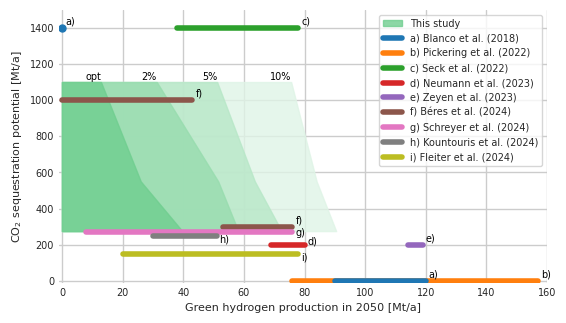

In [14]:
# Plot thick horizontal lines from x="range-lower" to x="range-lower" and y="seq" (using corresponding columns in df)
fig, ax = plt.subplots(figsize=(16 * cm, 9 * cm))

study_labels = {
    "blanco": "a) Blanco et al. (2018)",
    "pickering": "b) Pickering et al. (2022)",
    "seck": "c) Seck et al. (2022)",
    "neumann": "d) Neumann et al. (2023)",
    "zeyen": "e) Zeyen et al. (2023)",
    "beres": "f) Béres et al. (2024)",
    "schreyer": "g) Schreyer et al. (2024)",
    "kountouris": "h) Kountouris et al. (2024)",
    "fleiter": "i) Fleiter et al. (2024)",
}

# Colormap by studyname
cmap = plt.get_cmap("tab10")
colors = {name: cmap(i) for i, name in enumerate(lit_review["study-name"].unique())}

# Shade horizontally between range-lower and range-upper for current study, again using "seq" as y-coord
lighten = {0.0: 0.1, 0.02: 0.35, 0.05: 0.55, 0.10: 0.8}
slack_labels = {0.0: "opt", 0.02: "2%", 0.05: "5%", 0.10: "10%"}
# for imports in current_ranges.I.unique():
for slack in reversed(sorted(current_ranges.slack.unique())):
    d = current_ranges[(current_ranges.slack == slack)]
    ax.fill_betweenx(
        d["C"],
        d["h2prod"]["min"],
        d["h2prod"]["max"],
        color=lighten_color(green, lighten[slack]),
        alpha=0.8,
        label=f"This study",
    )
    # Annotate slack level at upper right corner of shaded area
    C = d["C"].max()
    ax.text(
        d.loc[d.C == C, "h2prod"]["max"],
        C,
        slack_labels[slack],
        fontsize=labelsize,
        verticalalignment="bottom",
        horizontalalignment="right",
        color="black",
    )

annot_y_shift = {
    "pickering": 10,
    "blanco": 10,
    "seck": 10,
    "neumann": -10,
    "zeyen": 10,
    "beres": 10,
    "schreyer": -30,
    "kountouris": -50,
    "fleiter": -50,
}
for i, row in lit_review.iterrows():
    if row["range-lower"] == row["range-upper"]:
        ax.plot(
            row["range-lower"],
            row["seq"],
            "o",
            color=colors[row["study-name"]],
            markersize=5,
            label=study_labels[row["study-name"]],
        )
    else:
        ax.plot(
            [row["range-lower"], row["range-upper"]],
            [row["seq"], row["seq"]],
            color=colors[row["study-name"]],
            linewidth=4,
            solid_capstyle="round",
            label=study_labels[row["study-name"]],
        )
    # Place annotation at the end of the line: first letter of study name
    ax.text(
        row["range-upper"] + 1,
        row["seq"] + annot_y_shift[row["study-name"]],
        study_labels[row["study-name"]][0] + ")",
        fontsize=labelsize,
        verticalalignment="bottom",
        horizontalalignment="left",
        color="black",
    )

# Increase zorder of line with blanco et al. data. Find line by label
for line in ax.lines:
    if line.get_label() == study_labels["blanco"]:
        line.set_zorder(10)

ax.set_xlim(-1, 160)
ax.set_ylim(-10, 1500)

# Grid
# ax.grid(True, which="minor", linestyle="--", linewidth=0.5)
ax.grid(True, which="major", linestyle="-", linewidth=1)

# Splines off
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

# Legend; remove duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=labelsize)

# Axis labels
ax.set_xlabel("Green hydrogen production in 2050 [Mt/a]", fontsize=textsize)
ax.set_ylabel("CO$_2$ sequestration potential [Mt/a]", fontsize=textsize)

# Tick marks off
ax.tick_params(axis="both", which="both", length=0, labelsize=labelsize)

plt.savefig("figures/lit_review_ranges.pdf", bbox_inches="tight", transparent=True)
plt.show()

# Plots

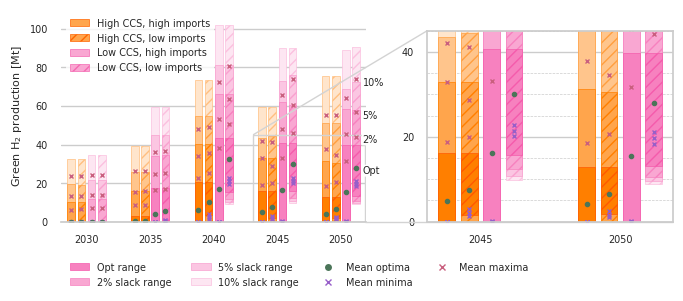

In [15]:
# Plot vertical bars going from minimum to maximum value of h2prod. One group of
# bars for each time horizon. Each group consists of four bars, one for each
# combination of CCS and imports scenario.

fig, ax = plt.subplots(figsize=(10 * cm, 7 * cm))

scenarios_to_plot = [
    ({"C": "c", "I": "b"}, "High CCS, high imports", plt.get_cmap("Set1")(4), dict()),
    (
        {"C": "c", "I": "a"},
        "High CCS, low imports",
        plt.get_cmap("Set1")(4),
        dict(hatch="///"),
    ),
    ({"C": "a", "I": "b"}, "Low CCS, high imports", plt.get_cmap("Set1")(7), dict()),
    (
        {"C": "a", "I": "a"},
        "Low CCS, low imports",
        plt.get_cmap("Set1")(7),
        dict(hatch="///"),
    ),
]

lighten_by_slack = {
    0.0: 0.0,
    0.02: 0.3,
    0.05: 0.55,
    0.1: 0.8,
}

rect_style = dict(
    linewidth=0.5,
)

bar_width = 0.6  # in years
bar_gap = 0.2  # in years


def plot_bars(ax, mark_min=False):
    for y in df.index.get_level_values("horizon").unique():
        # Get the data for the current time horizon
        data = df.xs(level="horizon", key=y)

        # For each slack level
        for slack in reversed(
            data.index.get_level_values("slack").unique().sort_values()
        ):
            # Get the data for the current slack level
            data_slack = data.xs(level="slack", key=slack)

            # For each combination of CCS and imports
            for j, (S, label, color, attrs) in enumerate(scenarios_to_plot):
                # Get the data for the current combination of CCS and imports
                d = data_slack
                for k, v in S.items():
                    d = d.xs(v, level=k)

                # Plot a rectangle from min to max h2prod
                ax.add_patch(
                    plt.Rectangle(
                        (
                            y + (j - 2) * (bar_width + bar_gap) + bar_gap / 2,
                            d.h2prod.min(),
                        ),
                        bar_width,
                        d.h2prod.max() - d.h2prod.min(),
                        facecolor=lighten_color(color, lighten_by_slack[slack]),
                        edgecolor=lighten_color(color, lighten_by_slack[slack] - 0.3),
                        **rect_style,
                        **attrs,
                    )
                )

                # Add a dot showing the mean value of opt, min and max h2prod
                if slack == 0.0:
                    ax.plot(
                        y
                        + (j - 2) * (bar_width + bar_gap)
                        + bar_gap / 2
                        + bar_width / 2,
                        d.xs("opt", level="sense").h2prod.mean(),
                        marker="o",
                        color=dark_green,
                        linewidth=0,
                        markersize=3,
                    )
                else:
                    for sense, color in zip(["min", "max"], [min_c, max_c]):
                        ax.plot(
                            y
                            + (j - 2) * (bar_width + bar_gap)
                            + bar_gap / 2
                            + bar_width / 2,
                            d.xs(sense, level="sense").h2prod.mean(),
                            marker="x",
                            color=color,
                            linewidth=0,
                            markersize=3,
                        )

                if mark_min and slack == 0.02:
                    # Place a star at minimum value of h2prod in the 0.02 slack scenario
                    ax.plot(
                        y
                        + (j - 2) * (bar_width + bar_gap)
                        + bar_gap / 2
                        + bar_width / 2,
                        d.h2prod.min(),
                        marker="x",
                        color=min_c,
                        markersize=6,
                    )


plot_bars(ax)


# Add text annotations for slack level at max h2prod value in last scenario of
# last time horizon. Add text just below and to the right of h2prod value.
def annotate_slack(ax, y, sense):
    for slack in reversed(df.index.get_level_values("slack").unique().sort_values()):
        d = df.xs(level="slack", key=slack)
        (S, label, color, attrs) = scenarios_to_plot[-1]
        d_slack = d.xs(level="horizon", key=y)
        for k, v in S.items():
            d_slack = d_slack.xs(v, level=k)
        # Annotation at (y, d_slack.h2prod.max()), offset 3pts down and right
        # h = d_slack.h2prod.max() if sense == "max" else d_slack.h2prod.min()
        h = (
            d_slack.xs(sense, level="sense").h2prod.mean()
            if slack > 0
            else d_slack.h2prod.mean()
        )
        ax.annotate(
            f"{slack:.0%}" if slack > 0 else "Opt",
            xy=(y + 2 * bar_width + 1.5 * bar_gap, h),
            xytext=(2, -2) if sense == "max" else (2, 2),
            textcoords="offset points",
            va="center",  # "top" if sense == "max" else "bottom",
            ha="left",
            size=labelsize,
            # Background color
            bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.1"),
        )


annotate_slack(ax, 2050, "max")


# Add a zoomed inset axis focussing on x=2045-2050 and y=0-50; place the inset axis to the right of the main axis
axins = zoomed_inset_axes(
    ax,
    zoom=2.2,
    loc="lower left",
    bbox_to_anchor=(1.2, 0),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
plot_bars(axins, mark_min=False)
axins.set_xlim(2043.1, 2051.9)
axins.set_ylim(0, 45)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="lightgrey")
annotate_slack(axins, 2040, "min")

# Minor y grid
axins.yaxis.grid(True, which="minor", linestyle="--", linewidth=0.5)

# Set ticks interacts in the inset axis
axins.xaxis.set_major_locator(plt.MultipleLocator(5))
axins.yaxis.set_major_locator(plt.MultipleLocator(20))
axins.yaxis.set_minor_locator(plt.MultipleLocator(5))


# Set limits
ax.set_ylim(bottom=0, top=H2_MAX)
ax.set_xlim(2028, 2052)

# Legend
handles = [
    plt.Rectangle(
        (0, 0),
        1,
        1,
        facecolor=lighten_color(color, 0.3),
        edgecolor=lighten_color(color, -0.2),
        **rect_style,
        **attrs,
    )
    for _, _, color, attrs in scenarios_to_plot
]
labels = [label for _, label, _, _ in scenarios_to_plot]
l = ax.legend(handles, labels, loc="upper left", fontsize=labelsize, edgecolor="none")
ax.add_artist(l)

# Add a second legend, located underneath the main axis, with the dot and
# crosses for mean opt, min, max values as well as shaded boxes for opt, 2%, 5%
# and 10% ranges.
handles = [
    plt.Rectangle(
        (0, 0),
        1,
        1,
        facecolor=lighten_color(plt.get_cmap("Set1")(7), lightness),
        edgecolor=lighten_color(plt.get_cmap("Set1")(7), lightness - 0.3),
        **rect_style,
        label=re.sub(r"^0% slack", "Opt", f"{slack:.0%} slack range"),
    )
    for slack, lightness in lighten_by_slack.items()
] + [
    # Markers
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="none",
        markerfacecolor=dark_green,
        markeredgewidth=0,
        markersize=5,
        label="Mean optima",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="x",
        color="none",
        markeredgecolor=min_c,
        markersize=5,
        label="Mean minima",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="x",
        color="none",
        markeredgecolor=max_c,
        markersize=5,
        label="Mean maxima",
    ),
]

ax.legend(
    handles=handles,
    fontsize=labelsize,
    ncol=4,
    loc="upper left",
    bbox_to_anchor=(0.0, -0.15),
    frameon=False,
)
# ax.add_artist(l)

for a in [ax, axins]:
    # Size of tick labels
    a.tick_params(axis="both", which="major", labelsize=labelsize)

    # Turn off x-grid
    a.xaxis.grid(False)

# Turn off spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Y label
ax.set_ylabel("Green H$_2$ production [Mt]", fontsize=textsize)

# Save
plt.savefig(
    "figures/CCS_imports_bars.pdf", dpi=300, bbox_inches="tight", transparent=True
)
plt.show()

Ranges at opt:
slack     
0.0    0.0     0.0
       1.0    39.7
Name: h2prod, dtype: float64
Ranges at min:
slack     
0.02   0.0    -0.0
       1.0    29.6
0.05   0.0    -0.0
       1.0    27.0
0.10   0.0    -0.0
       1.0    25.5
Name: h2prod, dtype: float64
Ranges at max:
slack     
0.02   0.0     6.5
       1.0    58.2
0.05   0.0    16.3
       1.0    72.4
0.10   0.0    31.3
       1.0    90.4
Name: h2prod, dtype: float64


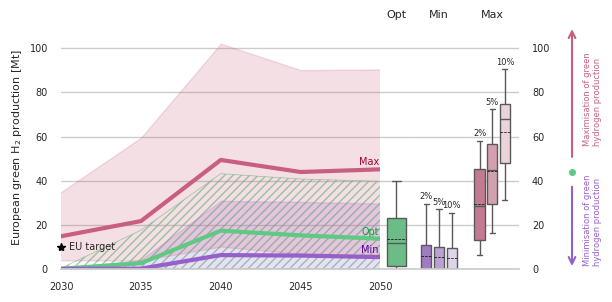

In [16]:
fig, axs = plt.subplots(
    1,
    4,
    figsize=(15 * cm, 8 * cm),
    sharey=True,
    gridspec_kw={"width_ratios": [3, 0.3, 0.5, 0.5], "wspace": 0},
)

df_sel = df.copy()

sns.lineplot(
    data=df_sel.xs("opt", level="sense"),
    x="horizon",
    y="h2prod",
    color=green,
    linewidth=3,
    errorbar=("pi", 100),
    # Make hatched
    err_kws=dict(hatch="////", edgecolor=green, facecolor="none", linewidth=0.5, alpha=0.7),
    ax=axs[0],
)

sns.lineplot(
    data=df_sel.xs("min", level="sense"),
    x="horizon",
    y="h2prod",
    color=min_c,
    linewidth=3,
    errorbar=("pi", 100),
    ax=axs[0],
)

sns.lineplot(
    data=df_sel.xs("max", level="sense"),
    x="horizon",
    y="h2prod",
    color=max_c,
    linewidth=3,
    errorbar=("pi", 100),
    ax=axs[0],
)


# Box plot of 2050 on the right
data = df_sel.xs(2050, level="horizon").copy()
# Add column "hue"; combination of sense and slack index levels
data["hue"] = data.index.get_level_values("sense") + data.index.get_level_values(
    "slack"
).map(lambda x: f"_{x:.2f}")

palette = {"opt_0.00": green}
lighten = {0.0: 0, 0.02: 0.1, 0.05: 0.35, 0.10: 0.7}
for slack in data.index.get_level_values("slack").unique():
    palette[f"min_{slack:.2f}"] = lighten_color(min_c, lighten[slack])
    palette[f"max_{slack:.2f}"] = lighten_color(max_c, lighten[slack])

for i, sense in enumerate(["opt", "min", "max"]):
    sns.boxplot(
        data=data.xs(sense, level="sense"),
        y="h2prod",
        x="slack",
        hue="hue",
        palette=palette,
        whis=(0, 100),
        ax=axs[i + 1],
        showmeans=True,
        meanline=True,
        meanprops={"color": "black", "linestyle": "--", "linewidth": 0.5},
    )

    # Pretty print maximum and minimum corresponding to whisker values
    print(f"Ranges at {sense}:")
    print(
        data.xs(sense, level="sense")
        .groupby("slack")["h2prod"]
        .quantile([0, 1])
        .round(1)
    )

    # Annotate nicely formatted slack level on top of whiskers for i > 0
    if i > 0:
        for j, slack in enumerate(
            data.xs(sense, level="sense").index.get_level_values("slack").unique()
        ):
            y = data.xs(sense, level="sense").xs(slack, level="slack")["h2prod"]
            y_max = y.max()
            axs[i + 1].text(
                j,
                y_max + 1,
                f"{slack:.0%}",
                va="bottom",
                ha="center",
                size=labelsize - 1,
            )


ax = axs[0]
ax.set_ylim(0, H2_MAX)
ax.set_xlim(2030, 2050)

# Turn off x-grid
ax.xaxis.grid(False)

# Turn off spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Set ticks at every 5 years
ax.xaxis.set_major_locator(plt.MultipleLocator(5))

# Tick size
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Set labels
ax.set_ylabel("European green H$_2$ production [Mt]", fontsize=textsize)
ax.set_xlabel(None)

# Annotate median values at 2050
for sense, color in zip(["opt", "min", "max"], [green, min_c, max_c]):
    y = df.xs(sense, level="sense").xs(2050, level="horizon")["h2prod"]
    y_val = y.mean() + 1
    ax.text(
        2049.9,
        y_val,
        sense.capitalize(),
        va="bottom",
        ha="right",
        size=labelsize,
        color=lighten_color(color, -0.6),
    )

# Add black star marker at (2030, 10) to indicate EU target, and annotate
ax.plot(2030, 10, marker="*", color="black", markersize=6, clip_on=False)
ax.text(2030.5, 10, "EU target", va="center", ha="left", size=labelsize)


for ax, name in zip(axs[1:], ["Opt", "Min", "Max"]):
    # Extend the x axis limits a bit in relative terms
    x0, x1 = ax.get_xlim()
    ax.set_xlim(x0 - 0.2 * (x1 - x0), x1 + 0.2 * (x1 - x0))

    # Turn of frame
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Turn off legend
    ax.get_legend().remove()

    # Turn off x ticks
    ax.set_xticks([])

    # Turn off seaborn group labels
    ax.set_xlabel(None)

    # Set name, but at bottom
    ax.set_title(name, fontsize=textsize)


# Tick labels on the right
axs[-1].yaxis.set_tick_params(labelright=True, labelsize=labelsize)


# Finally, draw two vertical arrows to the right of the last plot, one pointing
# down and one pointing up (blue and red respectively). They both  start at one
# third of the height of the axis. Use annotate to draw, and figure coordinates
ax = axs[-1]
xfrac = 2
ymid = 0.4
ax.annotate(
    "",
    xy=(xfrac, 0),
    xytext=(xfrac, ymid - 0.05),
    xycoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=1.5, color=min_c),
)
ax.annotate(
    "",
    xy=(xfrac, 1),
    xytext=(xfrac, ymid + 0.05),
    xycoords="axes fraction",
    arrowprops=dict(arrowstyle="->", lw=1.5, color=max_c),
)
# Draw a green round dot at ymid
ax.plot(
    xfrac,
    ymid,
    marker="o",
    color=green,
    markersize=4,
    clip_on=False,
    transform=ax.transAxes,
)

# Place some vertical text next to (to the right) of the arrows, vertically
# centred on each arrow.
ax.text(
    xfrac + 0.2,
    ymid / 2,
    "Minimisation of green\nhydrogen production",
    va="center",
    ha="left",
    transform=ax.transAxes,
    rotation=90,
    color=min_c,
    fontsize=labelsize - 1,
)
ax.text(
    xfrac + 0.2,
    (1 + ymid) / 2,
    "Maximisation of green\nhydrogen production",
    va="center",
    ha="left",
    transform=ax.transAxes,
    rotation=90,
    color=max_c,
    fontsize=labelsize - 1,
)


fig.savefig("figures/pathways.pdf", dpi=300, bbox_inches="tight", transparent=True)

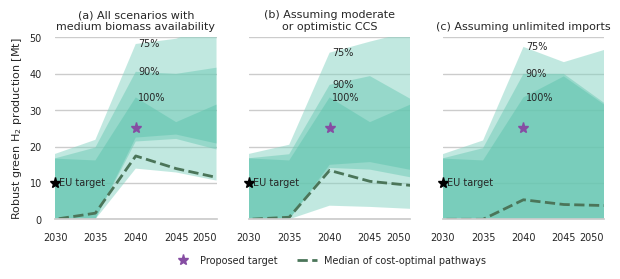

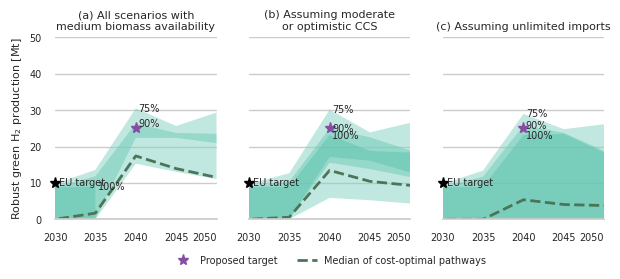

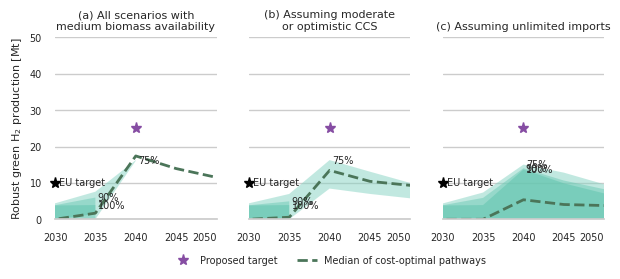

In [17]:
# Plot bands representing the range between maximum green hydrogen production
# over scenarios in cost (sense) minimisation, and minimum production over
# scenarios in cost maximisation (for each slack level)

robust_colour = "#5dc4ad"
target_colour = "#864da3"


def plot_robust_ranges(data, quantiles, slack, ax, plot_targets=True, max_y=50):
    upper = {
        q: data.xs("max", level="sense")
        .groupby(["horizon", "slack"])["h2prod"]
        .quantile(1 - q)
        for q in quantiles
    }
    lower = {
        q: data.xs("min", level="sense")
        .groupby(["horizon", "slack"])["h2prod"]
        .quantile(q)
        for q in quantiles
    }

    quantile_colors = {q: lighten_color(robust_colour, (1 - q)) for q in quantiles}

    for q in quantiles:
        ax.fill_between(
            lower[q].index.get_level_values("horizon").unique(),
            lower[q].xs(slack, level="slack"),
            upper[q].xs(slack, level="slack"),
            where=(
                upper[q].xs(slack, level="slack") >= lower[q].xs(slack, level="slack")
            ),
            color=quantile_colors[q],
            alpha=0.5,
            edgecolor="none",
            # label=f"{slack:.0%}",
            label=None,
        )

    # Plot median cost-optimal pathway
    sns.lineplot(
        data=data.xs("opt", level="sense"),
        x="horizon",
        y="h2prod",
        color=dark_green,
        linewidth=2,
        linestyle="--",
        estimator=np.median,
        errorbar=None,
        ax=ax,
    )

    # Make an annotation of the quantiles
    if len(quantiles) > 1:
        for q in quantiles:
            # select last year where upper is greater than lower
            year = min(
                (
                    upper[q]
                    .xs(slack, level="slack")
                    .index[
                        (
                            upper[q].xs(slack, level="slack")
                            - lower[q].xs(slack, level="slack")
                        )
                        > 1
                    ]
                    .max()
                ),
                2040,
            )
            # year = 2040
            y = upper[q].xs(slack, level="slack").loc[year]
            ax.text(year + 0.3, y, f"{q:.0%}", va="center", ha="left", size=labelsize)

    # Add black star marker at (2030, 10) to indicate EU target, and annotate
    ax.plot(2030, 10, marker="*", color="black", markersize=8, clip_on=False)
    ax.text(2030.5, 10, "EU target", va="center", ha="left", size=labelsize)

    # Add star markers at (2040, 30) and (2050, 45) to indicate proposed targets
    if plot_targets:
        ax.plot(
            targets[0][0],
            targets[0][1],
            marker="*",
            color=target_colour,
            markersize=8,
            clip_on=False,
            label="Proposed target",
            linewidth=0,
        )
        if len(targets) > 1:
            ax.plot(
                targets[1][0],
                targets[1][1],
                marker="*",
                color=target_colour,
                markersize=8,
                clip_on=False,
            )

    ax.set_xlim(2030, 2050)
    ax.set_ylim(0, max_y)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set ticks at every 5 years
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))

    # Tick size
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    # Set labels
    ax.set_xlabel(None)

    # Right-justify the tick label that says "2050" in axs[0]
    for tick in ax.xaxis.get_majorticklabels():
        if tick.get_text() == "2050":
            tick.set_horizontalalignment("right")


for slack_level in [0.1, 0.05, 0.02]:
    fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True)

    quantiles = [0.75, 0.9, 1]

    df_copy = df.xs("b", level="B").copy()
    # df_copy = df.copy()
    plot_robust_ranges(df_copy, quantiles, slack_level, axs[0])

    # Select only data where "C" index level is in ["b", "c"]
    df_selection = df_copy.loc[
        df_copy.index.get_level_values("C").isin(["b", "c"])
    ].copy()
    plot_robust_ranges(df_selection, quantiles, slack_level, axs[1])

    # Select only data where "I" index level is "b"
    df_selection = df_copy.xs("b", level="I").copy()
    plot_robust_ranges(df_selection, quantiles, slack_level, axs[2])

    axs[0].set_ylabel("Robust green H$_2$ production [Mt]", fontsize=textsize)

    # Add a single legend underneath middle plot, with two entries: "Proposed targets" and "Cost-optimal pathway".
    # Have to make manual phantom line to get the legend to show the dashed line
    handles, labels = axs[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    by_label["Median of cost-optimal pathways"] = axs[1].plot(
        [], [], color=dark_green, linestyle="--", linewidth=2
    )[0]
    axs[1].legend(
        by_label.values(),
        by_label.keys(),
        loc="lower center",
        fontsize=labelsize,
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.5, -0.3),
    )

    # Plot titles
    for ax, title in zip(
        axs,
        [
            "(a) All scenarios with\nmedium biomass availability",
            "(b) Assuming moderate\nor optimistic CCS",
            "(c) Assuming unlimited imports",
        ],
    ):
        ax.set_title(title, fontsize=textsize)

    fig.savefig(
        f"figures/robustness_{slack_level}.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )

    plt.show()

In [18]:
# Just print the ranges for the core robust pathways (i.e. quantile=1)
df_copy = df.xs("b", level="B").copy()
lower = df_copy.xs("min", level="sense").groupby(["slack", "horizon"])["h2prod"].max()
upper = df_copy.xs("max", level="sense").groupby(["slack", "horizon"])["h2prod"].min()
display(pd.concat([lower, upper], axis=1, keys=["min", "max"]).round(1))

min   max
slack horizon            
0.02  2025     -0.0   3.8
      2030     -0.0   3.8
      2035      1.4   3.9
      2040     26.5  13.7
      2045     25.9   9.9
      2050     24.0   7.1
0.05  2025     -0.0   9.1
      2030     -0.0   8.8
      2035     -0.0   8.9
      2040     24.3  23.2
      2045     24.2  18.8
      2050     22.6  18.3
0.10  2025     -0.0  17.0
      2030     -0.0  16.7
      2035     -0.0  16.2
      2040     22.5  33.5
      2045     23.3  26.7
      2050     20.8  31.5

In [19]:
# Print median cost-optimal pathway
df.xs("b", level="B").xs("opt", level="sense").groupby("horizon")[
    "h2prod"
].median().round(1)

horizon
2025     0.0
2030     0.0
2035     1.7
2040    17.4
2045    13.9
2050    11.5
Name: h2prod, dtype: float64

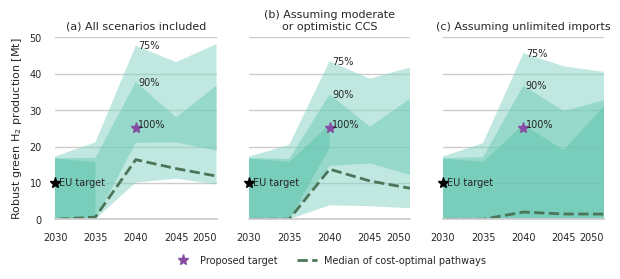

In [20]:
# ROBUSTNESS, including all biomass scenarios

fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True)

quantiles = [0.75, 0.9, 1]
slack_level = 0.1

df_copy = df.copy()
plot_robust_ranges(df_copy, quantiles, slack_level, axs[0])

# Select only data where "C" index level is in ["b", "c"]
df_selection = df_copy.loc[df_copy.index.get_level_values("C").isin(["b", "c"])].copy()
plot_robust_ranges(df_selection, quantiles, slack_level, axs[1])

# Select only data where "I" index level is "b"
df_selection = df_copy.xs("b", level="I").copy()
plot_robust_ranges(df_selection, quantiles, slack_level, axs[2])

axs[0].set_ylabel("Robust green H$_2$ production [Mt]", fontsize=textsize)

# Add a single legend underneath middle plot, with two entries: "Proposed targets" and "Cost-optimal pathway".
# Have to make manual phantom line to get the legend to show the dashed line
handles, labels = axs[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
by_label["Median of cost-optimal pathways"] = axs[1].plot(
    [], [], color=dark_green, linestyle="--", linewidth=2
)[0]
axs[1].legend(
    by_label.values(),
    by_label.keys(),
    loc="lower center",
    fontsize=labelsize,
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, -0.3),
)

# Plot titles
for ax, title in zip(
    axs,
    [
        "(a) All scenarios included",
        "(b) Assuming moderate\nor optimistic CCS",
        "(c) Assuming unlimited imports",
    ],
):
    ax.set_title(title, fontsize=textsize)

fig.savefig("figures/robustness_inc_biomass.pdf", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

/tmp/ipykernel_1880594/119285937.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


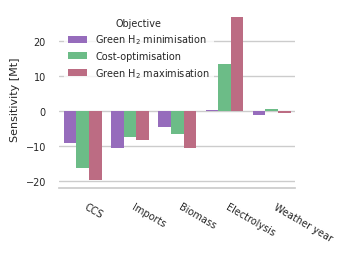

sense,a,b,min,opt,max
variable,,,,,
CCS,(a),\ $\rightarrow$ (c),-9.0,-16.3,-19.6
Electrolysis,(a),\ $\rightarrow$ (b),0.4,13.4,26.7
Imports,(a),\ $\rightarrow$ (b),-10.4,-7.4,-8.3
Biomass,(a),\ $\rightarrow$ (c),-4.5,-6.6,-10.5
Weather year,(a),\ $\rightarrow$ (b),-1.2,0.6,-0.6


In [21]:
# Global sensitivity analysis

horizon = 2050
# NB: Need to add "B" and "year" back when we have those values
cols = ["C", "I", "B", "E", "year"]
# cols = ["C", "I", "E"]
pretty_names = {
    "C": "CCS",
    "B": "Biomass",
    "I": "Imports",
    "E": "Electrolysis",
    "year": "Weather year",
}

scenario_changes = {
    "C": ["(a)", "\\ $\\rightarrow$ (c)"],
    "B": ["(a)", "\\ $\\rightarrow$ (c)"],
    "I": ["(a)", "\\ $\\rightarrow$ (b)"],
    "E": ["(a)", "\\ $\\rightarrow$ (b)"],
    "year": ["(a)", "\\ $\\rightarrow$ (b)"],
}

results = pd.DataFrame(index=cols)

for sense in ["min", "opt", "max"]:

    selection = df.xs(sense, level="sense").xs(horizon, level="horizon").copy()
    selection = selection.xs(0.05, level="slack") if sense != "opt" else selection
    selection.reset_index(inplace=True)

    # Drop rows where h2prod is NaN
    selection = selection.dropna(subset=["h2prod"])

    # Multivariable linear regression of h2prod with chosen columns
    for col in cols:
        selection[col] = selection[col].map(
            {"a": 0, "b": 1, "1987": 0, "2020": 1}
            if col in ["E", "I", "year"]
            else {"a": 0, "b": 0.5, "c": 1}
        )

    X = selection[cols]
    X = X.astype(float)

    X = sm.add_constant(X)
    y = selection["h2prod"]

    model = sm.OLS(y, X).fit()

    results[sense] = model.params[1:]


# Barplot of coefficients
fig, ax = plt.subplots(figsize=(8 * cm, 7 * cm))

# Make wide-form
results = results.T.reset_index().melt(
    id_vars="index", var_name="variable", value_name="coefficient"
)
results.rename(columns={"index": "sense"}, inplace=True)

palette = {"min": min_c, "opt": green, "max": max_c}
sns.barplot(
    data=results,
    ax=ax,
    x="variable",
    y="coefficient",
    hue="sense",
    palette=palette,
    edgecolor="none",
)

# Set labels
ax.set_ylabel("Sensitivity [Mt]", fontsize=textsize)
ax.set_xlabel(None)

# Rename x-ticks
ax.set_xticklabels(
    [pretty_names[t.get_text()] for t in ax.get_xticklabels()], rotation=-30, ha="left"
)

# Tick fontsize
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Format legend entries "min" -> "Minimisation", etc.
patches, labels = ax.get_legend_handles_labels()
l = ax.legend(
    patches,
    ["Green H$_2$ minimisation", "Cost-optimisation", "Green H$_2$ maximisation"],
    title="Objective",
    title_fontsize=labelsize,
    fontsize=labelsize,
)
l.get_frame().set_linewidth(0.0)

# Turn off spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

fig.subplots_adjust(bottom=0.3, left=0.15, top=0.95)

plt.show()

# Pivot to make values of "sense" column to columns, "coefficients" as values
results = results.pivot(index="variable", columns="sense", values="coefficient")
# Add scenario changes as two columns
results["a"] = [scenario_changes[col][0] for col in results.index]
results["b"] = [scenario_changes[col][1] for col in results.index]
# Use pretty names
results.index = results.index.map(pretty_names)
# Sort rows by decrease absolute value of opt
results = results.sort_values("opt", key=abs, ascending=False)
# Round to 1 decimal
results = results.round(1)
# Order columns from min to max
results = results[["a", "b", "min", "opt", "max"]]
display(results)
results.to_csv("figures/sensitivity.csv")

# Map

INFO:pypsa.io:Imported network base_s_60_lc1.5__Ca-Ia-Ea_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


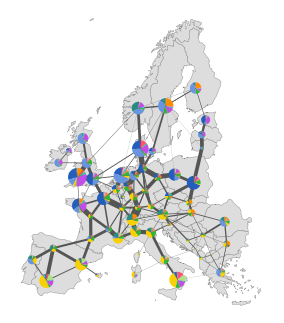

In [22]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue
            names = ifind.index[ifind == i]
            c.df.loc[names, "location"] = names.str[:i]

def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        "battery": "battery storage",
        "H2 for industry": "H2 for industry",
        "land transport fuel cell": "land transport fuel cell",
        "land transport oil": "land transport oil",
        "oil shipping": "shipping oil",
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "offwind-float": "offshore wind (Float)",
        "onwind": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "NH3": "ammonia",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label

def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    elif tech in ["H2 Electrolysis", "methanation", "H2 liquefaction"]:
        return "power-to-gas"
    elif tech == "H2":
        return "H2 storage"
    elif tech in ["NH3", "Haber-Bosch", "ammonia cracker", "ammonia store"]:
        return "ammonia"
    elif tech in ["OCGT", "CHP", "gas boiler", "H2 Fuel Cell"]:
        return "gas-to-power/heat"
    elif tech in ["Fischer-Tropsch", "methanolisation"]:
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    elif "CC" in tech or "sequestration" in tech:
        return "CCS"
    else:
        return tech
    
preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "solid biomass",
        "biogas",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "solar PV",
        "solar thermal",
        "solar rooftop",
        "solar",
        "building retrofitting",
        "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "power-to-heat",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "methanation",
        "ammonia",
        "hydrogen storage",
        "power-to-gas",
        "power-to-liquid",
        "battery storage",
        "hot water storage",
        "CO2 sequestration",
    ]
)

tech_colors = config_default["plotting"]["tech_colors"]

n = pypsa.Network("networks/base_s_60_lc1.5__Ca-Ia-Ea_2050.nc")

assign_location(n)
n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)

# Manually move Croatia node a degree north-west
n.buses.loc[n.buses.index.str.startswith("HR"), "x"] -= 2
n.buses.loc[n.buses.index.str.startswith("HR"), "y"] += 2.1

costs = pd.DataFrame(index=n.buses.index)

for comp in ["links", "stores", "storage_units", "generators"]:
    df_c = getattr(n, comp)

    if df_c.empty:
        continue

    df_c["nice_group"] = df_c.carrier.map(rename_techs_tyndp)

    attr = "e_nom_opt" if comp == "stores" else "p_nom_opt"

    costs_c = (
        (df_c.capital_cost * df_c[attr])
        .groupby([df_c.location, df_c.nice_group])
        .sum()
        .unstack()
        .fillna(0.0)
    )
    costs = pd.concat([costs, costs_c], axis=1)

costs = costs.T.groupby(costs.columns).sum().T

costs.drop(list(costs.columns[(costs == 0.0).all()]), axis=1, inplace=True)

new_columns = preferred_order.intersection(costs.columns).append(
    costs.columns.difference(preferred_order)
)
costs = costs[new_columns]

costs = costs.stack()  # .sort_index()

to_drop = costs.index.levels[0].symmetric_difference(n.buses.index)
if len(to_drop) != 0:
    costs.drop(to_drop, level=0, inplace=True, axis=0, errors="ignore")

# make sure they are removed from index
costs.index = pd.MultiIndex.from_tuples(costs.index.values)

threshold = 100e6  # 100 mEUR/a
carriers = costs.groupby(level=1).sum()
carriers = carriers.where(carriers > threshold).dropna()
carriers = list(carriers.index)


proj = ccrs.LambertConformal(
    central_longitude=10, central_latitude=50, standard_parallels=(35, 65)
)
fig, ax = plt.subplots(figsize=(18 * cm, 10 * cm), subplot_kw={"projection": proj})

bus_collection, _, _ = n.plot(
    ax=ax,
    bus_sizes=costs / 2e10,
    bus_colors=tech_colors,
    line_widths=n.lines.s_nom_opt / 8e3,
    line_colors="#555555",
    link_widths=n.links.p_nom_opt / 8e3,
    link_colors="#555555",
    color_geomap=False,
)
bus_collection.set_linewidth(0)


countries = config["countries"]  # Two letter country codes
# Convert to three-letter country codes
countries = [pycountry.countries.get(alpha_2=c).alpha_3 for c in countries]
# For each country, retrieve its shape and shade its area grey. Get their shapes from the Natural Earth dataset.
shpfilename = shpreader.natural_earth(
    resolution="50m", category="cultural", name="admin_0_countries"
)
shapes = shpreader.Reader(shpfilename).records()
for shape in shapes:
    if shape.attributes["ADM0_A3"] in countries:
        ax.add_geometries(
            [shape.geometry], ccrs.PlateCarree(), facecolor="#dddddd", edgecolor="#888888", linewidth=0.3
        )


# Axis boundaries: Europe
ax.set_extent([-10, 30, 35, 72], crs=ccrs.PlateCarree())

# Save as pdf
plt.savefig("figures/map.pdf", dpi=300, bbox_inches="tight", transparent=True)

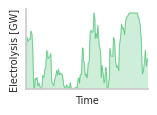

In [23]:
# Simple plot of total electrolysis production
fig, ax = plt.subplots(figsize=(4 * cm, 3 * cm))
elec_i = n.links.loc[n.links.carrier == "H2 Electrolysis"].index
elec = - n.links_t.p1.loc[:, elec_i].sum(axis=1) / 1e3
elec.plot(ax=ax, color=green, linewidth=0.5)
# Fill in the area under the curve
ax.fill_between(elec.index, elec, color=green, alpha=0.3)

# Set limits
ax.set_ylim(bottom=0)
# x: feb. 2020
ax.set_xlim(pd.Timestamp("1987-03-01"), pd.Timestamp("1987-04-01"))

# Remove all ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Remove grid
ax.grid(False)

# Axis labels
ax.set_ylabel("Electrolysis [GW]", fontsize=labelsize)
ax.set_xlabel("Time", fontsize=labelsize)

plt.savefig("figures/h2_prod_small.pdf", dpi=300, bbox_inches="tight", transparent=True)

# Hydrogen prices

Average marginal cost: -inf +-nan EUR/kg H2

Average marginal cost in 2025: 2.06 +-0.49 EUR/kg H2
Average marginal cost in 2030: 1.69 +-0.33 EUR/kg H2
Average marginal cost in 2035: 1.48 +-0.34 EUR/kg H2
Average marginal cost in 2040: 1.17 +-0.32 EUR/kg H2
Average marginal cost in 2045: 0.27 +-0.33 EUR/kg H2
Average marginal cost in 2050: 0.90 +-0.50 EUR/kg H2

Average marginal cost in 2%: 0.49 +-0.41 EUR/kg H2
Average marginal cost in 5%: 0.86 +-0.41 EUR/kg H2
Average marginal cost in 10%: 1.21 +-0.40 EUR/kg H2


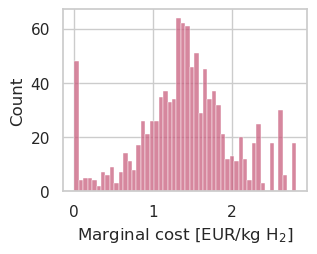

In [24]:
# Dual variables of system cost constraints of maximisation
values = -df.xs("max", level="sense").obj_bound_dual
# Correct for scaling of the objective bound
values = values * float(config["near_opt"]["obj_bound_scaling_factor"])
# Values are in MWh / EUR. Convert to kg H2 / EUR
kgH2_per_MWh = 1000 / 33.3
values *= kgH2_per_MWh
# Convert to EUR / kg H2
values = 1 / values
# Throw away values above 20; unrealistic
values = values[values < 20]
# Histogram
fig, ax = plt.subplots(figsize=(8 * cm, 6 * cm))
sns.histplot(values, bins=50, color=max_c, ax=ax)

# Set labels
ax.set_xlabel("Marginal cost [EUR/kg H$_2$]")
ax.set_ylabel("Count")

# Print average and sd
print(f"Average marginal cost: {values.mean():.2f} +-{values.std():.2f} EUR/kg H2")


# Now repeat the above for each time horizon
print("")
for y in sorted(df.index.get_level_values("horizon").unique()):
    values = -df.xs("max", level="sense").xs(y, level="horizon").obj_bound_dual * float(
        config["near_opt"]["obj_bound_scaling_factor"]
    )
    values *= kgH2_per_MWh
    # Filter out zero values
    values = values[values != 0]
    values = 1 / values
    # Throw away values above 20; unrealistic
    values = values[values < 20]
    print(
        f"Average marginal cost in {y}: {values.mean():.2f} +-{values.std():.2f} EUR/kg H2"
    )

# Now repeat for each slack level in 2050
print("")
for slack in sorted(
    df.xs(2050, level="horizon").index.get_level_values("slack").unique()
):
    if slack == 0:
        continue
    values = -df.xs("max", level="sense").xs(2050, level="horizon").xs(
        slack, level="slack"
    ).obj_bound_dual * float(config["near_opt"]["obj_bound_scaling_factor"])
    values *= kgH2_per_MWh
    values = values[values != 0]
    values = 1 / values
    values = values[values < 20]
    print(
        f"Average marginal cost in {slack:.0%}: {values.mean():.2f} +-{values.std():.2f} EUR/kg H2"
    )

In [25]:
df.xs(2050, level="horizon").xs("max", level="sense").obj_bound_dual

scenario  year  B  C  I  E  slack
1987aaaa  1987  a  a  a  a  0.02    -33.301240
                            0.05    -21.633627
                            0.10    -18.853898
1987abaa  1987  a  b  a  a  0.02    -28.003302
                            0.05    -25.393978
                                       ...    
2020cbbb  2020  c  b  b  b  0.05    -51.613496
                            0.10    -21.979329
2020ccbb  2020  c  c  b  b  0.02    -80.267716
                            0.05    -35.751654
                            0.10    -29.819418
Name: obj_bound_dual, Length: 216, dtype: float64

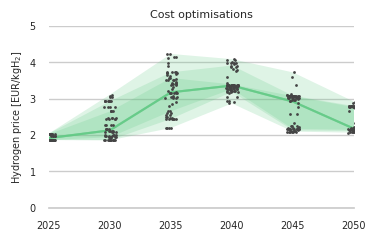

In [26]:
# Evolution of h2 price

fig, ax = plt.subplots(figsize=(10 * cm, 6 * cm))

per_mwh_to_per_kg = 33.3 / 1e3

df_copy = df.copy()
df_copy.h2price = df_copy.h2price * per_mwh_to_per_kg

sns.stripplot(
    data=df_copy.xs("opt", level="sense"),
    x="horizon",
    y="h2price",
    orient="v",
    native_scale=True,
    color="#444444",
    ax=ax,
    s=2,
)

for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
    sns.lineplot(
        data=df_copy.xs("opt", level="sense"),
        x="horizon",
        y="h2price",
        color=green,
        estimator=np.median,
        errorbar=("pi", quantile),
        err_kws={"edgecolor": "none"},
        alpha=alpha,
        ax=ax,
    )

ax.set_ylim(bottom=0, top=5)
ax.set_xlim(2025, 2050)

# Turn off x-grid
ax.xaxis.grid(False)

# Turn off spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Set labels
ax.set_ylabel("Hydrogen price [EUR/kgH$_2$]", fontsize=labelsize)
ax.set_xlabel(None)

# Tick font
ax.tick_params(axis="both", which="major", labelsize=labelsize)

ax.set_title("Cost optimisations", fontsize=textsize)

plt.savefig("figures/h2price.pdf", dpi=300, bbox_inches="tight", transparent=True)

# Correlations

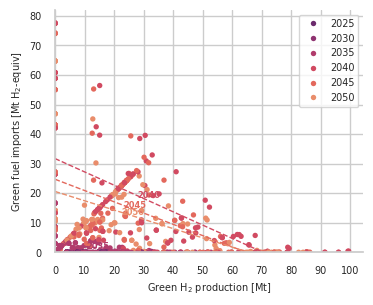

In [27]:
# Scatter plot of h2prod against imports

# Horizon palette based on Set2
horizon_palette = {y: sns.color_palette("flare_r")[i] for i, y in enumerate(df.index.get_level_values("horizon").unique())}

fig, ax = plt.subplots(figsize=(12 * cm, 8 * cm))

df_imports = df.copy()
df_imports.imports = df.imports / 33.3

sns.scatterplot(
    data=df_imports.xs("b", level="B"),
    x="h2prod",
    y="imports",
    hue="horizon",
    palette=horizon_palette,
    ax=ax,
    s=15,
    edgecolor="none",
)

# For each horizon, plot a line of best fit for all values with non-zero imports
for y in df_imports.index.get_level_values("horizon").unique():
    data = df_imports.xs("b", level="B").xs(y, level="horizon").copy()
    sns.regplot(
        data=data,
        x="h2prod",
        y="imports",
        scatter=False,
        ax=ax,
        color=horizon_palette[y],
        line_kws={"linestyle": "--", "linewidth": 1},
        ci=None,
    )

    # Annotation of the line of best fit
    if y >= 2035:
        x_an = data.h2prod.mean()
        y_an = data.imports.mean()
        ax.text(
            x_an + 0.5,
            y_an,
            y,
            va="center",
            ha="left",
            color=horizon_palette[y],
            fontsize=labelsize - 1,
            weight="bold",
        )

ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

# Set labels
ax.set_xlabel("Green H$_2$ production [Mt]", fontsize=labelsize)
ax.set_ylabel("Green fuel imports [Mt H$_2$-equiv]", fontsize=labelsize)

# Set ticks
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend font size
l = ax.legend(fontsize=labelsize)

# Equal aspect ratio
ax.set_aspect("equal")

# Grid at 10 Mt intervals
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))

plt.savefig("figures/h2prod_imports.pdf", dpi=300, bbox_inches="tight", transparent=True)

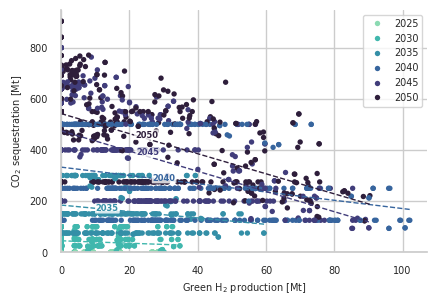

In [28]:
# Scatter plot of h2prod against carbon sequestration

# Horizon palette based on Set2
horizon_palette = {y: sns.color_palette("mako_r")[i] for i, y in enumerate(df.index.get_level_values("horizon").unique())}

fig, ax = plt.subplots(figsize=(12 * cm, 8 * cm))

df_copy = df.copy()
df_copy.co2seq = df.co2seq / 1e6

sns.scatterplot(
    data=df_copy,
    x="h2prod",
    y="co2seq",
    hue="horizon",
    palette=horizon_palette,
    ax=ax,
    s=15,
    edgecolor="none",
)

# For each horizon, plot a line of best fit for all values with non-zero imports
for y in df_copy.index.get_level_values("horizon").unique():
    data = df_copy.xs(y, level="horizon").copy()
    sns.regplot(
        data=data,
        x="h2prod",
        y="co2seq",
        scatter=False,
        ax=ax,
        color=horizon_palette[y],
        line_kws={"linestyle": "--", "linewidth": 1},
        ci=None,
    )

    # Annotation of the line of best fit
    if y >= 2035:
        x_an = data.h2prod.mean()
        y_an = data.co2seq.mean()
        ax.text(
            x_an + 0.5,
            y_an,
            y,
            va="center",
            ha="left",
            color=horizon_palette[y],
            fontsize=labelsize - 1,
            weight="bold",
            # Background color
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.1"),
        )

ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

# Set labels
ax.set_xlabel("Green H$_2$ production [Mt]", fontsize=labelsize)
ax.set_ylabel("CO$_2$ sequestration [Mt]", fontsize=labelsize)

# Set ticks
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend font size
l = ax.legend(fontsize=labelsize)

# Grid at 10 Mt intervals
# ax.xaxis.set_major_locator(plt.MultipleLocator(10))
# ax.yaxis.set_major_locator(plt.MultipleLocator(10))

plt.savefig("figures/h2prod_seq.pdf", dpi=300, bbox_inches="tight", transparent=True)

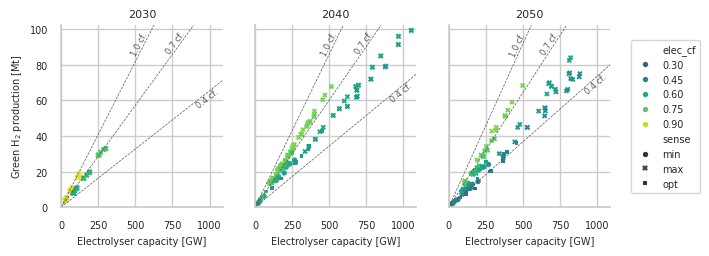

In [29]:
# Scatter plot of h2prod against electolyser capacity

# Horizon palette based on Set2
horizon_palette = {
    y: sns.color_palette("Set3")[i]
    for i, y in enumerate(df.index.get_level_values("horizon").unique())
}

fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True, sharex=True)

df_elec = df.copy()
df_elec.elec_cap = df_elec.elec_cap / 1e3  # Convert to GW

# Norm for colourscale based on elec_cf
norm = mpl.colors.Normalize(vmin=df_elec.elec_cf.min(), vmax=df_elec.elec_cf.max())

for i, h in enumerate([2030, 2040, 2050]):
    sns.scatterplot(
        data=df_elec.xs("b", level="B").xs(h, level="horizon"),
        x="elec_cap",
        y="h2prod",
        hue="elec_cf",
        palette="viridis",
        hue_norm=norm,
        style="sense",
        ax=axs[i],
        s=15,
        edgecolor="none",
    )

    # Plot dotted lines indicating capacity factors
    costs = pd.read_csv(f"../resources/Y1987_Bb/costs_{h}.csv", index_col=[0, 1])
    efficiency = costs.loc[("electrolysis", "efficiency"), "value"]
    x_max, y_max = df_elec.elec_cap.max(), df_elec.h2prod.max()
    x = x_max
    for cf in [0.4, 0.7, 1.0]:
        y = x * 8760 * efficiency * cf / 33.3 / 1e3
        axs[i].plot([0, x], [0, y], linestyle="--", color="#555555", linewidth=0.5)
        # Annotation of the line; place at the edge of the plotting region.
        # First, find the intersection of the line with the spines of the plot.
        x_intercept = x_max if y < y_max else x_max * (y_max / y)
        y_intercept = y if y < y_max else y_max
        axs[i].text(
            0.95 * x_intercept,
            0.95 * y_intercept,
            f"{cf} cf.",
            va="bottom" if cf > 0.4 else "top",
            ha="right",
            # Rotation based on the angle of the line, but convert axis coordinates to figure coordinates
            rotation=np.degrees(np.arctan(y / x)),
            rotation_mode='anchor',
            transform_rotates_text=True,
            color="#555555",
            fontsize=labelsize - 1,
        )

for ax in axs:
    ax.set_ylim(bottom=0, top=df_elec.h2prod.max())
    ax.set_xlim(left=0, right=df_elec.elec_cap.max())

    # Set labels
    ax.set_xlabel("Electrolyser capacity [GW]", fontsize=labelsize)
    ax.set_ylabel("Green H$_2$ production [Mt]", fontsize=labelsize)

    # Set ticks
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    # Spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Legend to the right of the last plot
l = axs[0].legend(
    fontsize=labelsize,
    # title="Capacity factor",
    # title_fontsize=labelsize,
    loc="center left",
    bbox_to_anchor=(3.5, 0.5),
)

# Disable legends for the other two plots
for ax in axs[1:]:
    ax.get_legend().remove()

# Titles
for i, h in enumerate([2030, 2040, 2050]):
    axs[i].set_title(f"{h}", fontsize=textsize)

plt.savefig(
    "figures/h2prod_elec_cap.pdf", dpi=300, bbox_inches="tight", transparent=True
)

# Evolution of other technologies

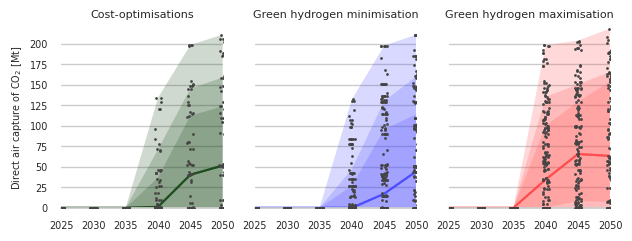

In [30]:
# DAC

fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {"opt": "Cost-optimisations", "min": "Green hydrogen minimisation", "max": "Green hydrogen maximisation"}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    # First a scatter-plot of dac 
    sns.stripplot(
        data=df.xs(sense, level="sense") / 1e6,
        x="horizon",
        y="dac",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense") / 1e6,
            x="horizon",
            y="dac",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0)
    ax.set_xlim(2025, 2050)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Direct air capture of CO$_2$ [Mt]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/DAC.pdf", dpi=300, bbox_inches="tight", transparent=True)

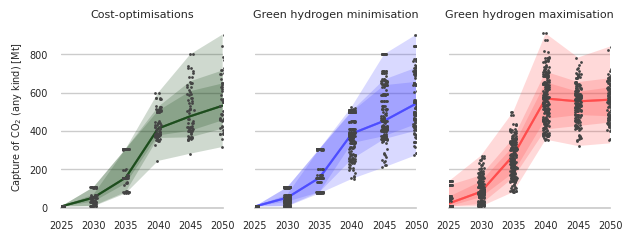

In [31]:
# Carbon capture of any kind

fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {"opt": "Cost-optimisations", "min": "Green hydrogen minimisation", "max": "Green hydrogen maximisation"}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    # First a scatter-plot of dac 
    sns.stripplot(
        data=df.xs(sense, level="sense"),
        x="horizon",
        y="captured_co2",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense"),
            x="horizon",
            y="captured_co2",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0)
    ax.set_xlim(2025, 2050)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Capture of CO$_2$ (any kind) [Mt]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/captured_co2.pdf", dpi=300, bbox_inches="tight", transparent=True)

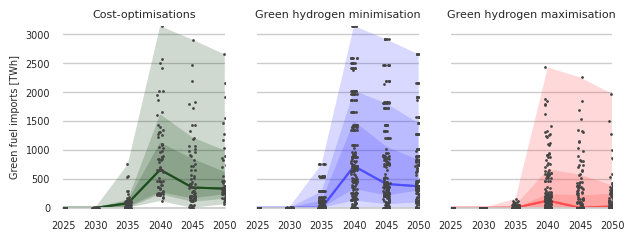

In [32]:
# IMPORTS

fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {"opt": "Cost-optimisations", "min": "Green hydrogen minimisation", "max": "Green hydrogen maximisation"}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    # First a scatter-plot of dac 
    sns.stripplot(
        data=df.xs(sense, level="sense"),
        x="horizon",
        y="imports",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense"),
            x="horizon",
            y="imports",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0, top=df.imports.max())
    ax.set_xlim(2025, 2050)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Green fuel imports [TWh]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/imports.pdf", dpi=300, bbox_inches="tight", transparent=True)

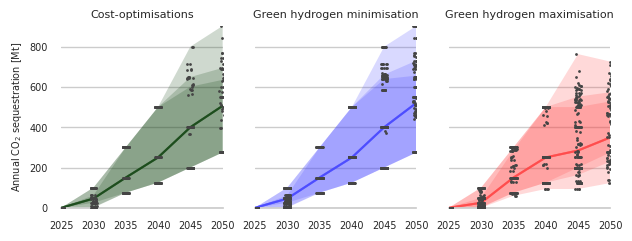

In [33]:
# Sequestration

fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {"opt": "Cost-optimisations", "min": "Green hydrogen minimisation", "max": "Green hydrogen maximisation"}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    # First a scatter-plot of dac 
    sns.stripplot(
        data=df.xs(sense, level="sense") / 1e6,
        x="horizon",
        y="co2seq",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense") / 1e6,
            x="horizon",
            y="co2seq",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0, top=df.co2seq.max() / 1e6)
    ax.set_xlim(2025, 2050)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Annual CO$_2$ sequestration [Mt]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/sequestration.pdf", dpi=300, bbox_inches="tight", transparent=True)

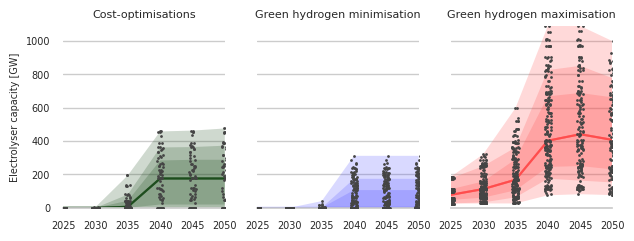

In [34]:
# Electrolyser capacity

fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {"opt": "Cost-optimisations", "min": "Green hydrogen minimisation", "max": "Green hydrogen maximisation"}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    sns.stripplot(
        data=df.xs(sense, level="sense") / 1e3,
        x="horizon",
        y="elec_cap",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense") / 1e3,
            x="horizon",
            y="elec_cap",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0, top=df.elec_cap.max() / 1e3)
    ax.set_xlim(2025, 2050)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Electrolyser capacity [GW]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/elec_cap.pdf", dpi=300, bbox_inches="tight", transparent=True)

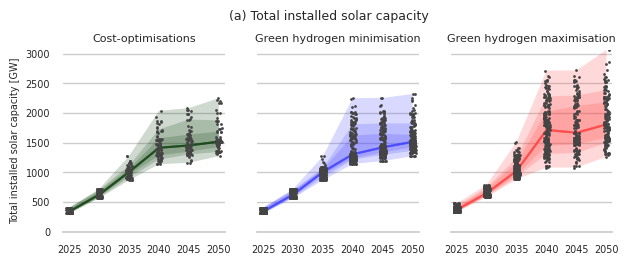

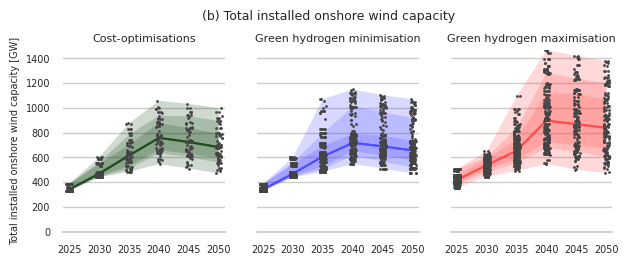

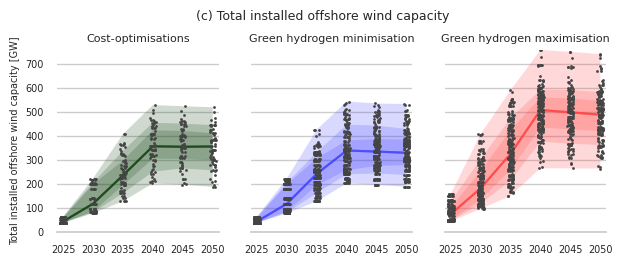

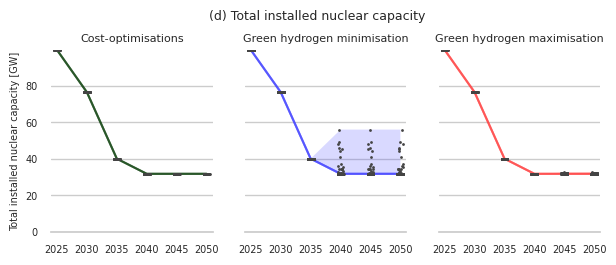

In [35]:
# Renewables + nuclear

pretty_names = {"solar": "solar", "onwind": "onshore wind", "offwind": "offshore wind", "nuclear": "nuclear"}

for j, carrier in enumerate(["solar", "onwind", "offwind", "nuclear"]):

    fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True)

    palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

    # Sense pretty names
    sense_pretty = {"opt": "Cost-optimisations", "min": "Green hydrogen minimisation", "max": "Green hydrogen maximisation"}

    for i, sense in enumerate(["opt", "min", "max"]):
        ax = axs[i]

        # First a scatter-plot of dac 
        sns.stripplot(
            data=df.xs(sense, level="sense") / 1e3,
            x="horizon",
            y=f"total_{carrier}",
            orient="v",
            native_scale=True,
            color="#444444",
            ax=ax,
            s=2,
        )

        for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
            sns.lineplot(
                data=df.xs(sense, level="sense") / 1e3,
                x="horizon",
                y=f"total_{carrier}",
                color=palette[sense],
                estimator=np.median,
                errorbar=("pi", quantile),
                err_kws={"edgecolor": "none"},
                alpha=alpha,
                ax=ax,
            )

        ax.set_ylim(bottom=0, top=df[f"total_{carrier}"].max() / 1e3)
        ax.set_xlim(2024, 2051)

        # Turn off x-grid
        ax.xaxis.grid(False)

        # Turn off spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        # Set labels
        ax.set_ylabel(f"Total installed {pretty_names[carrier]} capacity [GW]", fontsize=labelsize)
        ax.set_xlabel(None)

        # Tick font
        ax.tick_params(axis="both", which="major", labelsize=labelsize)

        # X ticks every 5 years
        ax.xaxis.set_major_locator(plt.MultipleLocator(5))

        ax.set_title(sense_pretty[sense], fontsize=textsize)

    # Title figure
    fig.suptitle(f"{['(a)', '(b)', '(c)', '(d)'][j]} Total installed {pretty_names[carrier]} capacity", fontsize=titlesize, y=1.05)

    plt.savefig(f"figures/{carrier}.pdf", dpi=300, bbox_inches="tight", transparent=True)

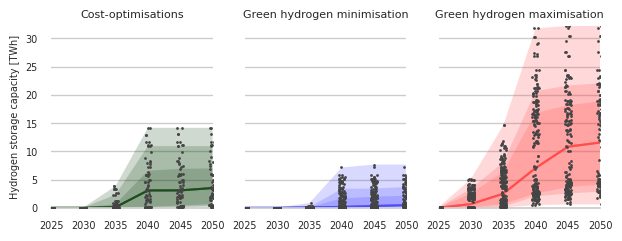

In [36]:
# H2 storage capacity

fig, axs = plt.subplots(1, 3, figsize=(18 * cm, 6 * cm), sharey=True)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {"opt": "Cost-optimisations", "min": "Green hydrogen minimisation", "max": "Green hydrogen maximisation"}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    sns.stripplot(
        data=df.xs(sense, level="sense") / 1e6,
        x="horizon",
        y="total_h2_storage",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense") / 1e6,
            x="horizon",
            y="total_h2_storage",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0, top=df.total_h2_storage.max() / 1e6)
    ax.set_xlim(2025, 2050)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Hydrogen storage capacity [TWh]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/h2_storage.pdf", dpi=300, bbox_inches="tight", transparent=True)